# Chessboard Recognition



In [84]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

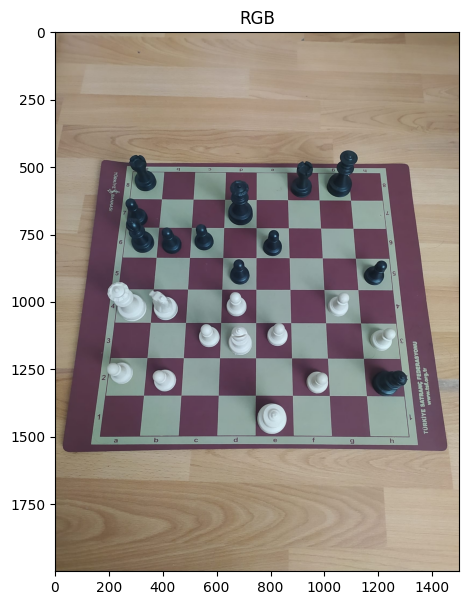

In [85]:
image_path = r"../data/test-images/test-10.jpeg"
image = cv2.imread(image_path) # opencv reads images as BGR format

gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(9,7))
plt.imshow(rgb_image)
plt.title("RGB");

## Processing the image

### Gaussian Blur, OTSU Thresholding, Canny Edge Detection, Dilation, Hough Transform

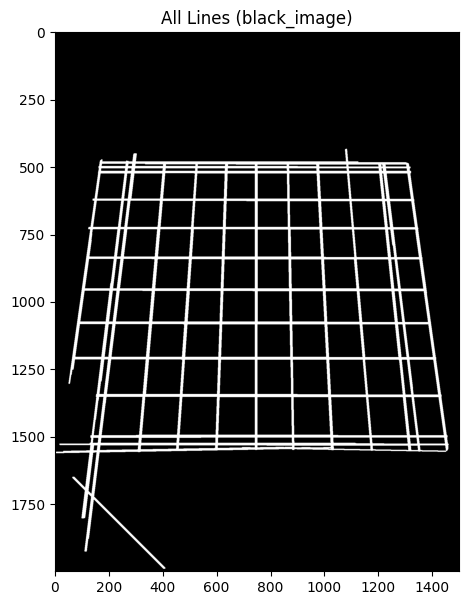

In [86]:
# Gaussian Blur (reduce noise)
gaussian_blur = cv2.GaussianBlur(gray_image,(5,5),0)

# OTSU threshold (thresholding to binary)
ret, otsu_binary = cv2.threshold(gaussian_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Canny edge detection (edge detection)
canny_image = cv2.Canny(otsu_binary, 20, 255)

# Dilation (increase the thickness of the lines)
kernel = np.ones((7, 7), np.uint8)
dilation_image = cv2.dilate(canny_image, kernel, iterations=1)

# Hough Lines (find straight lines)
lines = cv2.HoughLinesP(dilation_image, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)


# Create an image that contains only black pixels
black_image = np.zeros_like(dilation_image)

# Draw only lines that are output of HoughLinesP function to the "black_image"
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # draw only lines to the "black_image"
        cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Dilation
kernel = np.ones((3, 3), np.uint8)
black_image = cv2.dilate(black_image, kernel, iterations=1)

plt.figure(figsize=(9,7))
plt.title("All Lines (black_image)")
plt.imshow(black_image,cmap="gray");

## Contour Detection

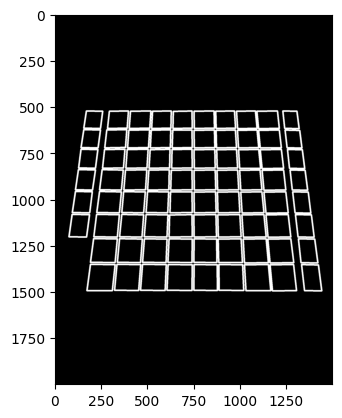

In [87]:
import cv2
import matplotlib.pyplot as plt

# find contours --> img_dilation_2
board_contours, hierarchy = cv2.findContours(black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

square_centers=list()

# draw filtered rectangles to image for visualization
board_squares = np.zeros_like(black_image)

for contour in board_contours:
    if 4000 < cv2.contourArea(contour) < 20000:
        # Approximate the contour to a simpler shape
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Ensure the approximated contour has 4 points (quadrilateral)
        if len(approx) == 4:
            pts = [pt[0] for pt in approx]  # Extract coordinates

            # Define the points explicitly
            pt1 = tuple(pts[0])
            pt2 = tuple(pts[1])
            pt4 = tuple(pts[2])
            pt3 = tuple(pts[3])

            x, y, w, h = cv2.boundingRect(contour)
            center_x=(x+(x+w))/2
            center_y=(y+(y+h))/2

            square_centers.append([center_x,center_y,pt2,pt1,pt3,pt4])

             

            # Draw the lines between the points
            cv2.line(board_squares, pt1, pt2, (255, 255, 0), 7)
            cv2.line(board_squares, pt1, pt3, (255, 255, 0), 7)
            cv2.line(board_squares, pt2, pt4, (255, 255, 0), 7)
            cv2.line(board_squares, pt3, pt4, (255, 255, 0), 7)


plt.imshow(board_squares,cmap="gray")

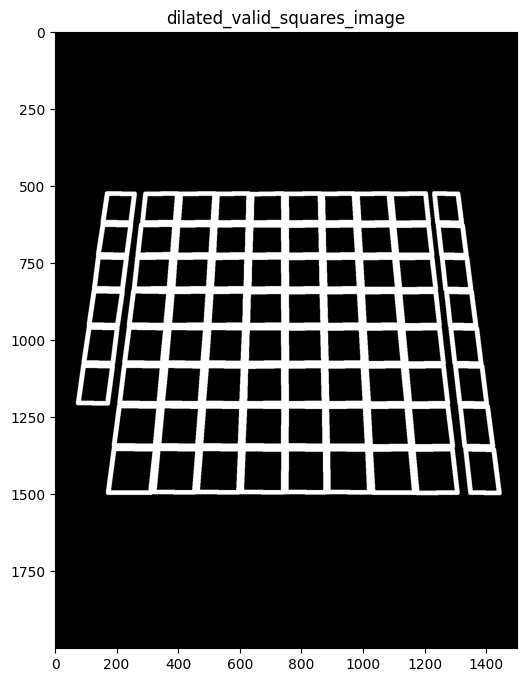

In [88]:
# Apply dilation to the valid_squares_image
kernel = np.ones((7, 7), np.uint8)
dilated_valid_squares_image = cv2.dilate(board_squares, kernel, iterations=1)

plt.figure(figsize=(12,8))
plt.title("dilated_valid_squares_image")
plt.imshow(dilated_valid_squares_image,cmap="gray")

## Find the chessboard outline

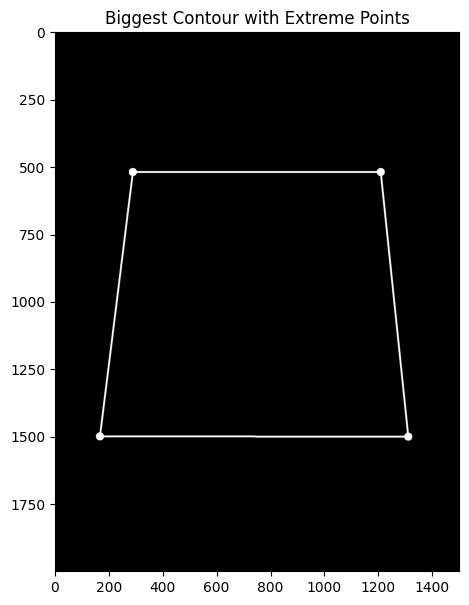

Top-left: (np.int32(288), np.int32(519))
Top-right: (np.int32(1206), np.int32(519))
Bottom-left: (np.int32(166), np.int32(1500))
Bottom-right: (np.int32(1308), np.int32(1501))


In [89]:
# Find contours of dilated_valid_squares_image
contours, _ = cv2.findContours(dilated_valid_squares_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if contours:
    # take biggest contour 
    largest_contour = max(contours, key=cv2.contourArea)

    # create black image
    biggest_area_image = np.zeros_like(dilated_valid_squares_image)

    # Initialize variables to store extreme points
    top_left, top_right, bottom_left, bottom_right = None, None, None, None

    # Loop through the contour to find extreme points
    for point in largest_contour[:, 0]:
        x, y = point

        if top_left is None or (x + y < top_left[0] + top_left[1]):
            top_left = (x, y)

        if top_right is None or (x - y > top_right[0] - top_right[1]):
            top_right = (x, y)

        if bottom_left is None or (x - y < bottom_left[0] - bottom_left[1]):
            bottom_left = (x, y)

        if bottom_right is None or (x + y > bottom_right[0] + bottom_right[1]):
            bottom_right = (x, y)

    # Mark the extreme points
    cv2.circle(biggest_area_image, top_left, 15, (255, 255, 255), -1)
    cv2.circle(biggest_area_image, top_right, 15, (255, 255, 255), -1)
    cv2.circle(biggest_area_image, bottom_left, 15, (255, 255, 255), -1)
    cv2.circle(biggest_area_image, bottom_right, 15, (255, 255, 255), -1)
    
    # Draw lines between the corners to form the chessboard outline
    cv2.line(biggest_area_image, top_left, top_right, (255, 255, 255), 5)
    cv2.line(biggest_area_image, top_left, bottom_left, (255, 255, 255), 5)
    cv2.line(biggest_area_image, top_right, bottom_right, (255, 255, 255), 5)
    cv2.line(biggest_area_image, bottom_left, bottom_right, (255, 255, 255), 5)

    plt.figure(figsize=(9, 7))
    plt.title("Biggest Contour with Extreme Points")
    plt.imshow(biggest_area_image, cmap="gray")
    plt.show()

    # Print out the extreme points
    print("Top-left:", top_left)
    print("Top-right:", top_right)
    print("Bottom-left:", bottom_left)
    print("Bottom-right:", bottom_right)

## Perspective Transform

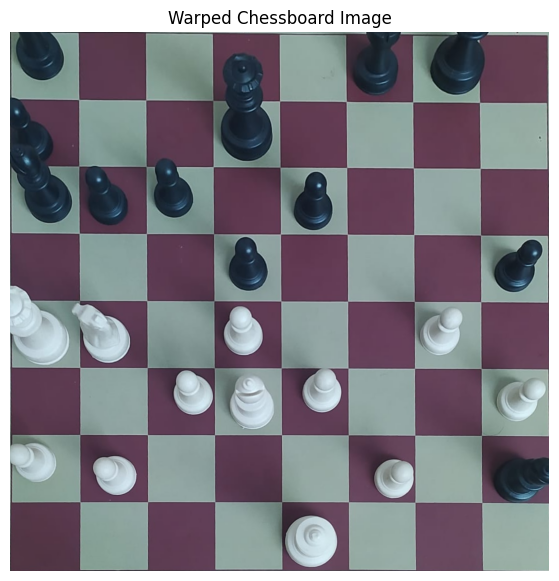

In [90]:
# Size of the output image
width, height = 1200, 1200

# Prepare the source points
src_points = np.array([
    top_left,
    top_right,
    bottom_right,
    bottom_left
], dtype='float32')

# Prepare the destination points
dst_points = np.array([
    [0, 0],  # Top-left
    [width, 0],  # Top-right
    [width, height],  # Bottom-right
    [0, height]  # Bottom-left
], dtype='float32')


# Calculate the perspective transform matrix
perspective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)

# Apply the perspective transform to the original image
warped_image = cv2.warpPerspective(image, perspective_matrix, (width, height))

# Display the warped image
plt.figure(figsize=(9, 7))
plt.title("Warped Chessboard Image")
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.show()

## Find the chessboard squares

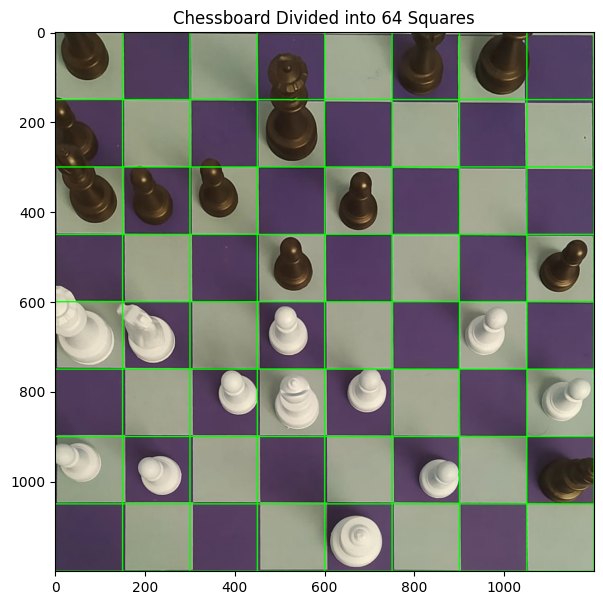

In [99]:
rows = 8
cols = 8

square_size = height // rows

# Draw the chessboard squares
for row in range(rows):
    for col in range(cols):
        top_left = (col * square_size, row * square_size)
        bottom_right = ((col+1) * square_size, (row+1) * square_size)
        
        # Draw the square
        cv2.rectangle(warped_image, top_left, bottom_right, (0, 255, 0), 2)

# Display the image
# Display the result
plt.figure(figsize=(9, 7))
plt.imshow(warped_image)
plt.title("Chessboard Divided into 64 Squares")
plt.show()